In [154]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor


from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel


In [155]:
from src import cols
from src.plots import plot_importance_reg
from src.get_metrics import get_metrics
from src.add_date_features import add_date_features

In [164]:
df_ventas = pd.read_parquet('data/01-ventas.parquet')
df_pos = pd.read_parquet('data/01-pos.parquet')

In [165]:
df_pos.drop(['SIN VENTAS','POCAS', 'MEDIO', 'MUCHAS'],errors='ignore',inplace=True,axis=1)

In [166]:
df_ventas.columns, df_pos.columns

(Index(['fecha', 'id_pos', 'unidades', 'dayofweek', 'year', 'month',
        'dayofyear', 'dayofmonth', 'weekofyear', 'is_weekend'],
       dtype='object'),
 Index(['competidores', 'ingreso_mediana', 'densidad_poblacional',
        'pct_secundario', 'pct_bicicleta', 'pct_omnibus', 'pct_subtes',
        'pct_taxi', 'pct_caminata', 'mediana_valor_hogar', 'pct_0a14',
        'pct_15a39', 'pct_40a59', 'pct_60aInf', 'sin_datos_estudios',
        'pct_posgrado', 'transporte_sin_datos'],
       dtype='object'))

In [167]:
df_ventas = (
    df_ventas.drop(['fecha'], axis=1)
    .groupby([
        "id_pos", 
#         'dayofweek',
        'year',
#         'month',
        'dayofyear',
#         'dayofmonth',
        'weekofyear', 
        'is_weekend'
     ])[['unidades']]
    .sum().reset_index()
)

In [168]:
df_pos_ventas = df_pos.merge(df_ventas, on="id_pos", how="left") #.drop('id_pos', axis=1)
df_pos_ventas.unidades.fillna(0, inplace=True)
df_pos_ventas.fillna(-1, inplace=True)

In [169]:
df_pos_ventas.columns

Index(['id_pos', 'competidores', 'ingreso_mediana', 'densidad_poblacional',
       'pct_secundario', 'pct_bicicleta', 'pct_omnibus', 'pct_subtes',
       'pct_taxi', 'pct_caminata', 'mediana_valor_hogar', 'pct_0a14',
       'pct_15a39', 'pct_40a59', 'pct_60aInf', 'sin_datos_estudios',
       'pct_posgrado', 'transporte_sin_datos', 'year', 'dayofyear',
       'weekofyear', 'is_weekend', 'unidades'],
      dtype='object')

In [162]:
df_pos_ventas = df_pos_ventas[lambda df: df.unidades>0]

In [123]:
X = (
    df_pos_ventas.loc[:,~df_pos_ventas.columns.isin(['unidades'])]
#     .drop(["POCAS", "MUCHAS", "MEDIO", "SIN VENTAS"], axis=1)
#     .drop(['year', 'month'], axis=1)
)
y = df_pos_ventas.loc[:,["unidades"]]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((166687, 21), (71438, 21), (166687, 1), (71438, 1))

In [125]:
def xbg_factory(
    max_depth=6, 
    learning_rate=0.1, 
    n_estimators=100,
    early_stopping_rounds=50
):
    return xgb.XGBRFRegressor(
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        max_depth=max_depth, 
        learning_rate=0.1, 
        n_estimators=n_estimators,
        early_stopping_rounds=50,
        verbose=True,
#         booster="gbtree",
        objective="reg:squarederror",
        missing=-1
    )

In [126]:
reg_xgb = xbg_factory()

In [127]:
# xgb_model = xgb.XGBRFRegressor()

# parameters = {
#     'max_depth':[6,7,8], 
#     'learning_rate':[0.1], 
#     'n_estimators':[10,50,100,200],
#     'early_stopping_rounds':[20],
#     'missing':[-1]
# }

# xgb_model = GridSearchCV(
#     xgb_model, parameters, 
#     n_jobs=4, 
#     cv=KFold(n_splits=3, shuffle=False), 
#     scoring='neg_mean_absolute_error',
#     verbose=2, 
#     refit=True,
#     return_train_score=True
# )

# xgb_model.fit(X,y)

In [128]:
# plot_importance_reg(xgb_model.best_estimator_, X.columns, "FI Random Forest")

In [131]:
reg_xgb.fit(X_train, y_train)

bias_predictions = reg_xgb.predict(X_train)
print(get_metrics(y_train, bias_predictions))
variance_predictions = reg_xgb.predict(X_test)
print( get_metrics(y_test, variance_predictions))
preds = reg_xgb.predict(X)
print(get_metrics(y, np.round(preds)))

{'explained_variance_score': 0.0138037210515638, 'mae': 1.784566530851314, 'r2': -0.4886918572005934}
{'explained_variance_score': 0.015553916506173104, 'mae': 2.078968497264819, 'r2': -0.5218205071876605}
{'explained_variance_score': 0.0, 'mae': 1.5681175853018372, 'r2': -0.3581234061052978}


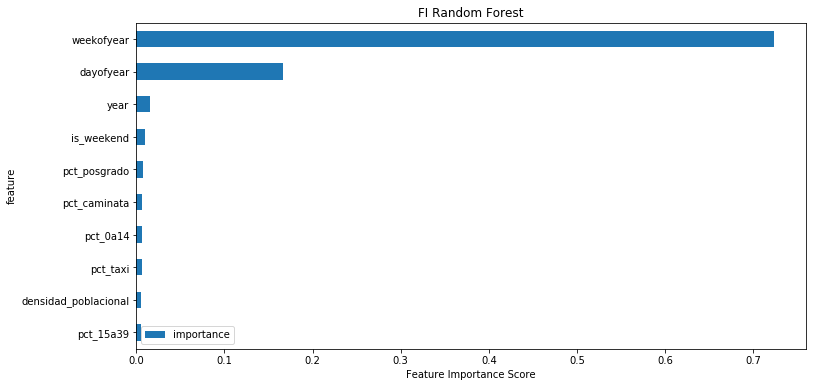

[(0.0033614563, 'competidores'),
 (0.003239891, 'ingreso_mediana'),
 (0.0057717925, 'densidad_poblacional'),
 (0.0046247663, 'pct_secundario'),
 (0.0042748163, 'pct_bicicleta'),
 (0.004790112, 'pct_omnibus'),
 (0.0036539268, 'pct_subtes'),
 (0.006341387, 'pct_taxi'),
 (0.00686739, 'pct_caminata'),
 (0.004933095, 'mediana_valor_hogar'),
 (0.006387384, 'pct_0a14'),
 (0.0052001164, 'pct_15a39'),
 (0.004702182, 'pct_40a59'),
 (0.004428327, 'pct_60aInf'),
 (0.004224511, 'sin_datos_estudios'),
 (0.0070421114, 'pct_posgrado'),
 (0.004283584, 'transporte_sin_datos'),
 (0.015921136, 'year'),
 (0.16637723, 'dayofyear'),
 (0.7235306, 'weekofyear'),
 (0.010044155, 'is_weekend')]

In [132]:
plot_importance_reg(reg_xgb, X.columns, "FI Random Forest")
[*zip(reg_xgb.feature_importances_, X_train.columns)]

In [133]:
# from src import cols
# models = []
# for cols in [cols.cols_edad, cols.cols_estudios, cols.cols_ingresos, cols.cols_otros]:
#     df_pos_ventas = (
#         df_pos.loc[:,cols]
#         .merge(df_ventas, on="id_pos", how="left")
#         .drop(['id_pos',"fecha"], axis=1)
#     )                
    
#     df_pos_ventas.unidades.fillna(0, inplace=True)
#     df_pos_ventas.fillna(0, inplace=True)
#     X = (
#         df_pos_ventas
#         .loc[:,~df_pos_ventas.columns.isin(['unidades'])]
# #         .drop(["POCAS", "MUCHAS", "MEDIO", "SIN VENTAS"], axis=1, errors='ignore')
#     )
#     y = df_pos_ventas.loc[:,["unidades"]]    
    
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=7)
    
#     reg_xgb = xbg_factory()
#     reg_xgb.fit(X_train, y_train)
    
#     bias_predictions = reg_xgb.predict(X_train)
#     print(get_metrics(y_train, bias_predictions))
    
#     variance_predictions = reg_xgb.predict(X_test)
#     print( get_metrics(y_test, variance_predictions))
    
#     preds = reg_xgb.predict(X)
#     print(get_metrics(y, np.round(preds)))
#     plot_importance_reg(reg_xgb, X.columns, "FI Random Forest")
#     models.append(reg_xgb)

In [134]:
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(reg_xgb, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: -50.45% (6.75%)


In [135]:
# # Fit model using each importance as a threshold
# thresholds = sorted(reg_xgb.feature_importances_)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(reg_xgb, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
       
#     # train model
#     selection_model = xbg_factory()
#     selection_model.fit(select_X_train, y_train)
       
#     # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred]
#     accuracy = metrics.mean_absolute_error(y_test, predictions)
    
#     print("Thresh=%.3f, n=%d, MAE: %.2f%" % (thresh, select_X_train.shape[1], accuracy))

    

In [144]:
final = pd.date_range(start="2014-12-01", periods=31)
final = pd.DataFrame(final, columns=["fecha"])

final = add_date_features(final)
final = final.drop('month', axis=1)

In [145]:
final = (
    final
    .assign(key=1)
    .merge(
        df_pos
        .reset_index()[["id_pos"]]
        .assign(key=1)
    )
    .drop('key', axis=1, errors='ignore')
)


In [146]:
final.drop(['fecha'], axis=1, errors='ignore', inplace=True)

In [147]:
final = df_pos.merge(final, on="id_pos", how="left").set_index('id_pos')
final.drop(['SIN VENTAS','POCAS', 'MEDIO', 'MUCHAS'],errors='ignore',inplace=True,axis=1)

In [148]:
final = final.loc[:,X.columns]

In [149]:
final.columns, X.columns

(Index(['competidores', 'ingreso_mediana', 'densidad_poblacional',
        'pct_secundario', 'pct_bicicleta', 'pct_omnibus', 'pct_subtes',
        'pct_taxi', 'pct_caminata', 'mediana_valor_hogar', 'pct_0a14',
        'pct_15a39', 'pct_40a59', 'pct_60aInf', 'sin_datos_estudios',
        'pct_posgrado', 'transporte_sin_datos', 'year', 'dayofyear',
        'weekofyear', 'is_weekend'],
       dtype='object'),
 Index(['competidores', 'ingreso_mediana', 'densidad_poblacional',
        'pct_secundario', 'pct_bicicleta', 'pct_omnibus', 'pct_subtes',
        'pct_taxi', 'pct_caminata', 'mediana_valor_hogar', 'pct_0a14',
        'pct_15a39', 'pct_40a59', 'pct_60aInf', 'sin_datos_estudios',
        'pct_posgrado', 'transporte_sin_datos', 'year', 'dayofyear',
        'weekofyear', 'is_weekend'],
       dtype='object'))

In [150]:
final.head()

competidores  ingreso_mediana  densidad_poblacional  pct_secundario  \
id_pos                                                                        
288.0      28.686117     55984.323314           11529.97762       28.307037   
288.0      28.686117     55984.323314           11529.97762       28.307037   
288.0      28.686117     55984.323314           11529.97762       28.307037   
288.0      28.686117     55984.323314           11529.97762       28.307037   
288.0      28.686117     55984.323314           11529.97762       28.307037   

        pct_bicicleta  pct_omnibus  pct_subtes  pct_taxi  pct_caminata  \
id_pos                                                                   
288.0        0.590323     2.203479    1.435632  0.157035      3.753466   
288.0        0.590323     2.203479    1.435632  0.157035      3.753466   
288.0        0.590323     2.203479    1.435632  0.157035      3.753466   
288.0        0.590323     2.203479    1.435632  0.157035      3.753466   
288.0        0.590323     2.203479    1.435632  0.157035      3.753466   

        mediana_valor_hogar  ...  pct_15a39  pct_40a59  pct_60aInf  \
id_pos                       ...                                     
288.0         220923.326912  ...  34.348226  26.104323   21.423842   
288.0         220923.326912  ...  34.348226  26.104323   21.423842   
288.0         220923.326912  ...  34.348226  26.104323   21.423842   
288.0         220923.326912  ...  34.348226  26.104323   21.423842   
288.0         220923.326912  ...  34.348226  26.104323   21.423842   

        sin_datos_estudios  pct_posgrado  transporte_sin_datos  year  \
id_pos                                                                 
288.0            43.936427       9.29841             91.860065  2014   
288.0            43.936427       9.29841             91.860065  2014   
288.0            43.936427       9.29841             91.860065  2014   
288.0            43.936427       9.29841             91.860065  2014   
288.0            43.936427       9.29841             91.860065  2014   

        dayofyear  weekofyear  is_weekend  
id_pos                                     
288.0         335          49           0  
288.0         336          49           0  
288.0         337          49           0  
288.0         338          49           0  
288.0         339          49           0  

[5 rows x 21 columns]

In [153]:
pos = df_ventas.id_pos.unique()

In [171]:
models = {}
for p in pos:
    m = RandomForestRegressor(criterion='mae')
    X = (
        df_pos_ventas
        .loc[lambda df: df.id_pos == p,~df_pos_ventas.columns.isin(['unidades'])]
        #.drop(["POCAS", "MUCHAS", "MEDIO", "SIN VENTAS"], axis=1)
        #.drop(['year', 'month'], axis=1)
    )
    y = df_pos_ventas.loc[lambda df: df.id_pos == p,["unidades"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=7)
    reg_xgb.fit(X_train, y_train)
    bias_predictions = reg_xgb.predict(X_train)
    print(get_metrics(y_train, bias_predictions))
    variance_predictions = reg_xgb.predict(X_test)
    print( get_metrics(y_test, variance_predictions))
    preds = reg_xgb.predict(X)
    print(get_metrics(y, np.round(preds)))
    models[p]=m


{'explained_variance_score': 0.07221504964326941, 'mae': 1.8776180843512218, 'r2': -0.3385169508246244}
{'explained_variance_score': -2.220446049250313e-16, 'mae': 0.5260999401410421, 'r2': -1.2455151615738362}
{'explained_variance_score': 0.0, 'mae': 1.1111111111111112, 'r2': -0.20242914979757054}
{'explained_variance_score': 0.04077930228186066, 'mae': 1.5625496745109557, 'r2': -2.064015081609772}
{'explained_variance_score': 0.0, 'mae': 4.715213859081269, 'r2': -1.6542590578029812}
{'explained_variance_score': 0.0, 'mae': 2.2666666666666666, 'r2': -0.6824085005903187}
{'explained_variance_score': 0.0796655193399659, 'mae': 1.3548792536769594, 'r2': -0.2653805293204696}
{'explained_variance_score': 0.02476047932011305, 'mae': 4.478954704908224, 'r2': -2.7005730874135674}
{'explained_variance_score': 0.0, 'mae': 1.975609756097561, 'r2': -0.47771952817824404}
{'explained_variance_score': 0.048690666990308995, 'mae': 0.7711422642072042, 'r2': -2.6272810954194514}
{'explained_variance_sc

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.054845928418202905, 'mae': 1.8187847852706909, 'r2': -1.2953492124520634}
{'explained_variance_score': 0.021993218504782308, 'mae': 1.499130395742563, 'r2': -1.1151601900019061}
{'explained_variance_score': -2.220446049250313e-16, 'mae': 1.3953488372093024, 'r2': -0.8348794063079779}
{'explained_variance_score': 0.07253355675518036, 'mae': 1.2190890974468656, 'r2': -1.373477691636638}
{'explained_variance_score': 0.028342661622835275, 'mae': 1.861018717288971, 'r2': -1.9507377190056716}
{'explained_variance_score': 0.0, 'mae': 1.0384615384615385, 'r2': -0.801980198019802}
{'explained_variance_score': 0.06185613213888064, 'mae': 1.6347458735108376, 'r2': -0.47938823666328867}
{'explained_variance_score': -0.056350126087631125, 'mae': 1.6434502005577087, 'r2': -1.6569003848806227}
{'explained_variance_score': 0.0, 'mae': 1.25, 'r2': -0.4054054054054055}
{'explained_variance_score': 0.0703606553476035, 'mae': 2.3529499570528665, 'r2': -0.35551422929817234}
{

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.04454362839381887, 'mae': 1.630434444972447, 'r2': -0.7851220243977601}
{'explained_variance_score': 0.00014020238067025126, 'mae': 2.002413483766409, 'r2': -1.2784116833454617}
{'explained_variance_score': 0.0, 'mae': 1.4146341463414633, 'r2': -0.6218114602587799}
{'explained_variance_score': 0.07395548367616, 'mae': 1.1051797179075389, 'r2': -1.0011505230933069}
{'explained_variance_score': 0.012013327096333293, 'mae': 0.7673379679520925, 'r2': -2.6376206796774757}
{'explained_variance_score': 0.0, 'mae': 0.5789473684210527, 'r2': -0.38291139240506333}
{'explained_variance_score': 0.07626200391268512, 'mae': 1.4379193852929508, 'r2': -0.6725348805932836}
{'explained_variance_score': 0.03302111539976604, 'mae': 3.292491110165914, 'r2': -0.7843756623707949}
{'explained_variance_score': 0.0, 'mae': 1.6326530612244898, 'r2': -0.3965303593556384}
{'explained_variance_score': 0.0678933301577207, 'mae': 1.9565270090103148, 'r2': -0.379302690518313}
{'explained

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.07651767644695595, 'mae': 1.3158868210656303, 'r2': -0.9807576901182304}
{'explained_variance_score': -0.020559759047961368, 'mae': 1.7551961541175842, 'r2': -2.5411435640354543}
{'explained_variance_score': 0.0, 'mae': 1.05, 'r2': -0.7124394184168015}
{'explained_variance_score': 0.06743129871491071, 'mae': 1.1412541192510854, 'r2': -0.1943475197996427}
{'explained_variance_score': 0.013249417133031294, 'mae': 2.0029516339302065, 'r2': -0.9329334243442517}
{'explained_variance_score': 0.0, 'mae': 1.0, 'r2': -0.20370370370370372}
{'explained_variance_score': 0.07737682153325254, 'mae': 2.380560678464395, 'r2': -0.3015018840671946}
{'explained_variance_score': 0.007169439316037751, 'mae': 3.545961851874987, 'r2': -0.697903535023541}
{'explained_variance_score': 0.0, 'mae': 2.4358974358974357, 'r2': -0.372287765035888}
{'explained_variance_score': 0.07284942037693876, 'mae': 1.9022304839209507, 'r2': -0.6857287293552832}
{'explained_variance_score': 0.02446

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.06632471241813598, 'mae': 2.9816518339018026, 'r2': -1.0209479987362462}
{'explained_variance_score': -0.0005875204811327528, 'mae': 3.216215823377882, 'r2': -0.56838979856713}
{'explained_variance_score': 0.0, 'mae': 2.7971014492753623, 'r2': -0.6964252327711926}
{'explained_variance_score': 0.030167734834099735, 'mae': 1.398673917566027, 'r2': -1.5364618489255788}
{'explained_variance_score': 0.0030742824073740627, 'mae': 3.9386287977298102, 'r2': -1.1395562751927004}
{'explained_variance_score': -2.220446049250313e-16, 'mae': 1.8, 'r2': -0.5134706814580032}
{'explained_variance_score': 0.056239722299815886, 'mae': 2.0109114136014665, 'r2': -1.6879897755371545}
{'explained_variance_score': 0.037350571772761576, 'mae': 2.835978601127863, 'r2': -1.2494933683960623}
{'explained_variance_score': 0.0, 'mae': 1.9607843137254901, 'r2': -1.0434056761268784}
{'explained_variance_score': 0.0, 'mae': 0.6938250064849854, 'r2': -2.56743007799408}
{'explained_varianc

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.03390559828314643, 'mae': 1.461071260770162, 'r2': -0.9874959467161404}
{'explained_variance_score': -0.005948824732811664, 'mae': 3.800808216844286, 'r2': -1.5447771116030746}
{'explained_variance_score': 0.0, 'mae': 1.8409090909090908, 'r2': -0.6064331269063681}
{'explained_variance_score': 0.08319405391688484, 'mae': 1.312279456428119, 'r2': -0.6963144099759624}
{'explained_variance_score': 0.0040914942062109105, 'mae': 2.7458488390995908, 'r2': -2.3820637645469582}
{'explained_variance_score': 0.0, 'mae': 1.3902439024390243, 'r2': -0.650841346153846}
{'explained_variance_score': 0.0627499893789335, 'mae': 1.4177260127934543, 'r2': -1.2790629360251948}
{'explained_variance_score': 0.029635535439756944, 'mae': 2.1675981998443605, 'r2': -1.6727129993314431}
{'explained_variance_score': 0.0, 'mae': 1.28125, 'r2': -0.8148327678138634}
{'explained_variance_score': 0.0649234480008487, 'mae': 1.7472091705902764, 'r2': -0.41771235582025934}
{'explained_varianc

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.052657007830284375, 'mae': 1.582797140986831, 'r2': -0.8532581258786576}
{'explained_variance_score': -0.0021456689012653296, 'mae': 5.208651145299275, 'r2': -0.5817787152652938}
{'explained_variance_score': 0.0, 'mae': 2.3333333333333335, 'r2': -0.285138764547896}
{'explained_variance_score': 0.05539963857298258, 'mae': 1.7533338516950607, 'r2': -0.5797614348773965}
{'explained_variance_score': -0.0030537273332482684, 'mae': 4.49300577905443, 'r2': -1.6715794164964484}
{'explained_variance_score': 0.0, 'mae': 2.2413793103448274, 'r2': -0.5797200878155875}
{'explained_variance_score': 0.08727948353029957, 'mae': 1.9088689386844635, 'r2': -0.4335512479152803}
{'explained_variance_score': 0.06138604918720536, 'mae': 2.7509854435920715, 'r2': -0.9832002173815773}
{'explained_variance_score': 0.0, 'mae': 1.826086956521739, 'r2': -0.4611764705882355}
{'explained_variance_score': 0.06637791455392761, 'mae': 3.1664373193468367, 'r2': -1.0434115860989408}
{'expla

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.08297726846627607, 'mae': 1.7842224568736798, 'r2': -0.6321670907445447}
{'explained_variance_score': -0.10767919679154758, 'mae': 0.8624285885265895, 'r2': -1.1327052405597131}
{'explained_variance_score': 0.0, 'mae': 1.1714285714285715, 'r2': -0.3905669144981414}
{'explained_variance_score': 0.10489651238532371, 'mae': 1.8543635218039802, 'r2': -1.0626601587042472}
{'explained_variance_score': 0.03607137928166093, 'mae': 1.7204736113548278, 'r2': -2.3510491427895674}
{'explained_variance_score': 0.0, 'mae': 1.4848484848484849, 'r2': -0.9067220543806649}
{'explained_variance_score': 0.08738491668924797, 'mae': 1.8556869316984106, 'r2': -0.8542375280216279}
{'explained_variance_score': 0.02519855441072627, 'mae': 1.869154155254364, 'r2': -0.6402752086568271}
{'explained_variance_score': 0.0, 'mae': 1.5128205128205128, 'r2': -0.5518389346861128}
{'explained_variance_score': 0.07484742784829901, 'mae': 1.3836608018193925, 'r2': -0.5078317243882395}
{'explai

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.0429475686252746, 'mae': 1.2913226996149336, 'r2': -1.057911432441331}
{'explained_variance_score': 0.003853996920233471, 'mae': 2.4806533217430116, 'r2': -1.3666673622500638}
{'explained_variance_score': -2.220446049250313e-16, 'mae': 1.2903225806451613, 'r2': -0.5974607916355492}
{'explained_variance_score': 0.07936023244644153, 'mae': 1.787645161151886, 'r2': -0.3537232941264805}
{'explained_variance_score': 0.05360704341630251, 'mae': 2.8927368842638455, 'r2': -1.435003071517491}
{'explained_variance_score': 0.0, 'mae': 1.7906976744186047, 'r2': -0.4489625927608665}
{'explained_variance_score': 0.1008816876091646, 'mae': 1.8602731894044315, 'r2': -1.070216815943171}
{'explained_variance_score': -0.003298346967508081, 'mae': 4.4306541830301285, 'r2': -1.445737583861368}
{'explained_variance_score': 0.0, 'mae': 2.36, 'r2': -0.711279117286473}
{'explained_variance_score': 0.09680659071306819, 'mae': 2.141431430975596, 'r2': -1.2238832384751461}
{'explain

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'explained_variance_score': 0.09104022413699642, 'mae': 1.5664923697710038, 'r2': -0.7669661900415963}
{'explained_variance_score': 0.020404469052998753, 'mae': 4.546356121699016, 'r2': -1.5355599108820557}
{'explained_variance_score': 0.0, 'mae': 2.1379310344827585, 'r2': -0.5677991137370753}
{'explained_variance_score': 0.05966043990947245, 'mae': 1.5061018019914627, 'r2': -0.8295298741716044}
{'explained_variance_score': 0.0012166531054651486, 'mae': 2.6464691857496896, 'r2': -0.9466659387757925}
{'explained_variance_score': 0.0, 'mae': 1.5, 'r2': -0.5232558139534884}
{'explained_variance_score': 0.05736501442988673, 'mae': 1.0537846569831555, 'r2': -1.5569841937983715}
{'explained_variance_score': 0.017857283356354947, 'mae': 1.797418584426244, 'r2': -0.6632887689720215}
{'explained_variance_score': 0.0, 'mae': 0.8947368421052632, 'r2': -0.3822751322751323}
{'explained_variance_score': 0.09021086854121418, 'mae': 1.831239736598471, 'r2': -0.6126295501048391}
{'explained_variance_s

ValueError: With n_samples=1, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [176]:
len(models.keys())

1226